# Causal Discovery example

The goal of this notebook is to show how causal discovery methods can work with DoWhy. We use discovery methods from [causal-learn](https://github.com/py-why/causal-learn) repo. As we will see, causal discovery methods require appropriate assumptions for the correctness guarantees, adn thus there will be variance across results returned by different methods in practice. These methods, however, may be combined usefully with domain knowledge to construct the final causal graph.

In [62]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Utility function
We define a utility function to draw the directed acyclic graph.

In [63]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

# Experiments on the Auto-MPG dataset

In this section, we will use a dataset on the technical specification of cars. The dataset is downloaded from UCI Machine Learning Repository. The dataset contains 9 attributes and 398 instances. We do not know the true causal graph for the dataset and will use CDT to discover it. The causal graph obtained will then be used to estimate the causal effect.


## 1. Load the data

In [64]:
data_mpg = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
                   delim_whitespace=True, header=None,
                   names = ['mpg', 'cylinders', 'displacement',
                            'horsepower', 'weight', 'acceleration',
                            'model year', 'origin', 'car name'])
data_mpg.dropna(inplace=True)
data_mpg.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)
print(data_mpg.shape)
data_mpg.head()

(392, 6)


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8.0,307.0,130.0,3504.0,12.0
1,15.0,8.0,350.0,165.0,3693.0,11.5
2,18.0,8.0,318.0,150.0,3436.0,11.0
3,16.0,8.0,304.0,150.0,3433.0,12.0
4,17.0,8.0,302.0,140.0,3449.0,10.5


# Causal Discovery with causal-learn

We use the CDT library to perform causal discovery on the Auto-MPG dataset. We use three methods for causal discovery here -PC, FCI and GES. These methods are widely used and do not take much time to run. Hence, these are ideal for an introduction to the topic. Causal-learn provides a comprehensive list of well-tested causal-discovery methods, and readers are welcome to explore.

The documentation for the methods used are as follows:
- PC [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html)
- GES [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Score-based%20causal%20discovery%20methods/GES.html)
- LiNGAM [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Causal%20discovery%20methods%20based%20on%20constrained%20functional%20causal%20models/lingam.html#ica-based-lingam)

We first try the PC algorithm with default parameters.

  0%|          | 0/6 [00:00<?, ?it/s]

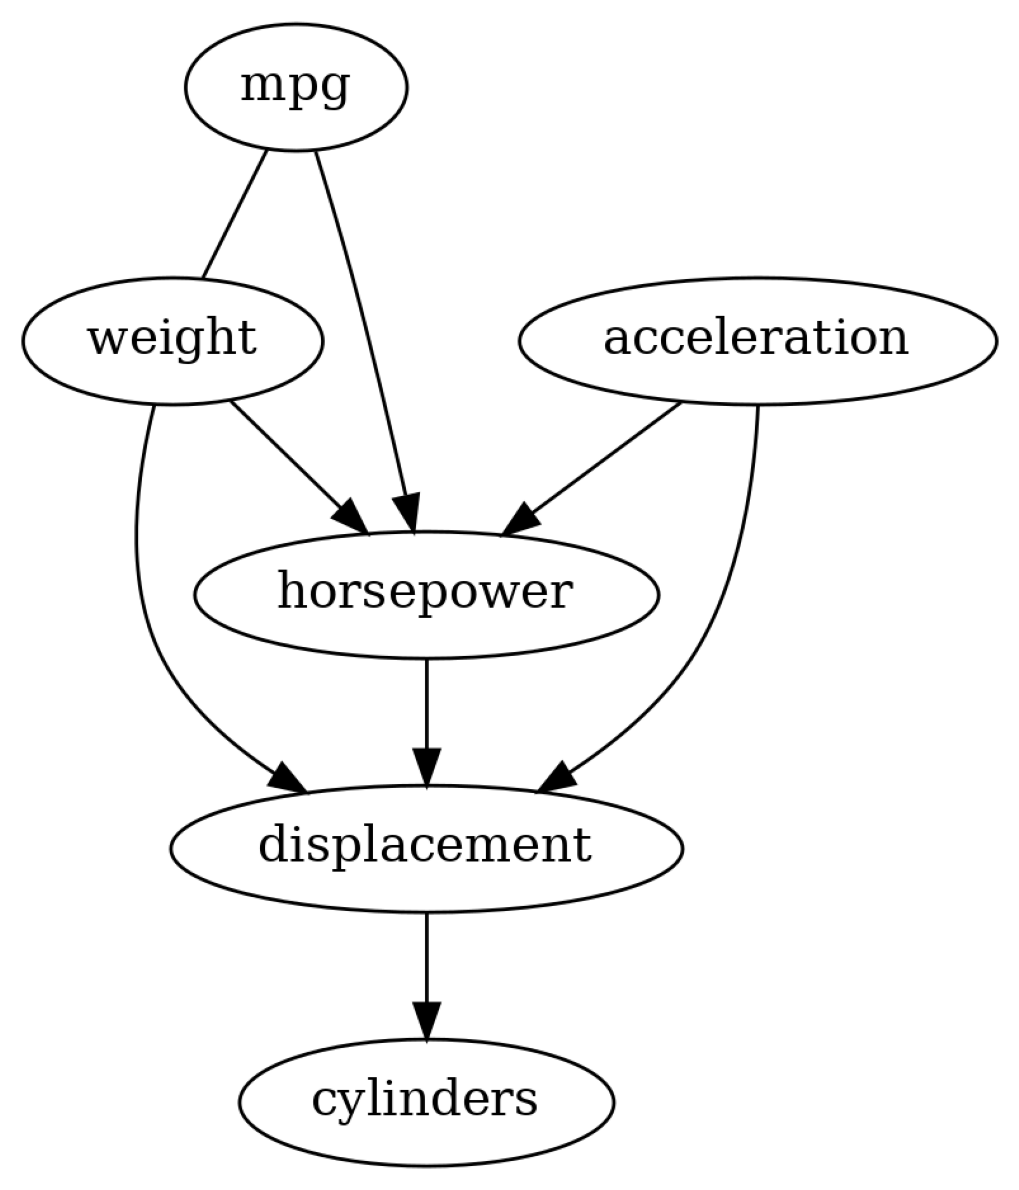

In [65]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data_mpg.columns)]
data = data_mpg.to_numpy()

cg = pc(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

Then we have a causal graph discovered by PC. Let us also try GES to see its result.

[[ 0  0  0  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0  0  1  0]
 [ 0  0  0  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0  1 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0 -1 -1  0]
 [ 0  0 -1  0  0  0]
 [ 1  0 -1  0  0  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0 -1 -1  0]
 [ 0  0 -1  0  0  1]
 [-1  0 -1  0  0  0]
 [ 0  0  0 -1  0  0]]
[[ 0  0  0  0 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0 -1 -1  0]
 [ 0  0 -1  0  0 -1]
 [-1  0 -1  0  0 -1]
 [ 0  0  0  1  1  0]]
[[ 0  0  0 -1 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0 -1 -1  0]
 [ 1  0  1  0  0 -1]
 [-1  0 -1  0  0 -1]
 [ 0  0  0  1  1  0]]
[[ 0  0  0 -1 -1  0]
 [ 0  0 -1  0  0  0]
 [ 0 -1  0 -1 -1 -1]
 [ 1  0  1  0  0 -1]
 [-1  0 -1  0  0 -1]
 [ 0  

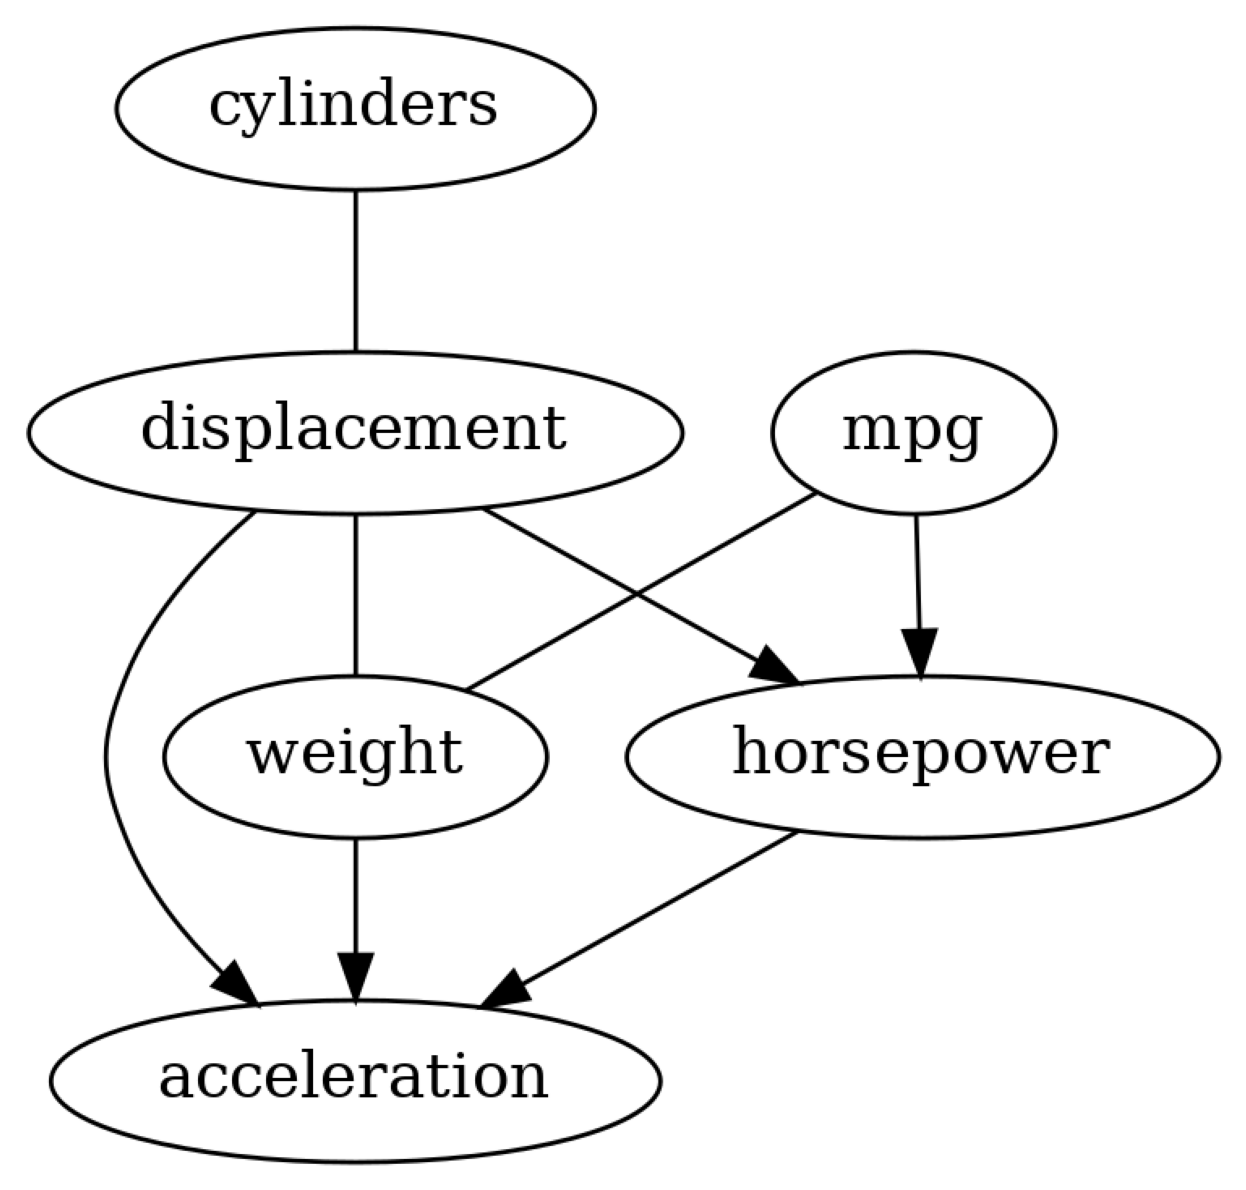

In [66]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

Well, these two results are different, which is not rare when applying causal discovery on real-world dataset, since the required assumptions on the data-generating process are hard to verify.

In addition, the graphs returned by PC and GES are CPDAGs instead of DAGs, so it is possible to have undirected edges (e.g., the result returned by GES). Thus, causal effect estimataion is difficult for those methods, since there may be absence of backdoor, instrumental or frontdoor variables. In order to get a DAG, we decide to try LiNGAM on our dataset.

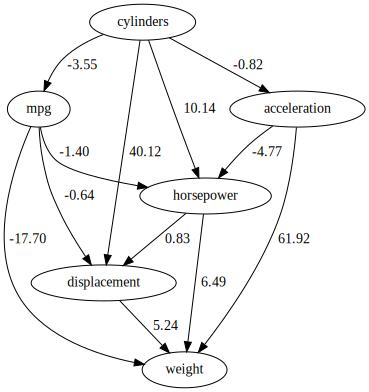

In [67]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

Now we have a DAG and are ready to estimate the causal effects based on that.

## Estimate causal effects using Linear Regression

Now let us see the estimate of causal effect of *mpg* on *weight*.

In [68]:
# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

# Define Causal Model
model=CausalModel(
        data = data_mpg,
        treatment='mpg',
        outcome='weight',
        graph=str_to_dot(graph_dot.source))

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
──────(E[weight|cylinders])
d[mpg]                     
Estimand assumption 1, Unconfoundedness: If U→{mpg} and U→weight then P(weight|mpg,cylinders,U) = P(weight|mpg,cylinders)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is -38.94097365620928


# Experiments on the Sachs dataset

The dataset consists of the simultaneous measurements of 11 phosphorylated proteins and phospholipids derived from thousands of individual primary immune system cells, subjected to both general and specific molecular interventions (Sachs et al., 2005).

The specifications of the dataset are as follows - 
- Number of nodes: 11
- Number of arcs: 17
- Number of parameters: 178
- Average Markov blanket size: 3.09
- Average degree: 3.09
- Maximum in-degree: 3
- Number of instances: 7466

The original causal graph is known for the Sachs dataset and we compare the original graph with the ones discovered using causal-learn in this section.

## 1. Load the data

In [69]:
from cdt.data import load_dataset
data_sachs, graph_sachs = load_dataset("sachs")

data_sachs.dropna(inplace=True)
print(data_sachs.shape)
data_sachs.head()

(7466, 11)


,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.2,8.82,18.30,58.80,6.61,17.0,414.0,17.00,44.9,40.0
1,35.9,16.5,12.30,16.80,8.13,18.60,32.5,352.0,3.37,16.5,61.5
2,59.4,44.1,14.60,10.20,13.00,14.90,32.5,403.0,11.40,31.9,19.5
3,73.0,82.8,23.10,13.50,1.29,5.83,11.8,528.0,13.70,28.6,23.1
4,33.7,19.8,5.19,9.73,24.80,21.10,46.1,305.0,4.66,25.7,81.3


## Ground truth of the causal graph

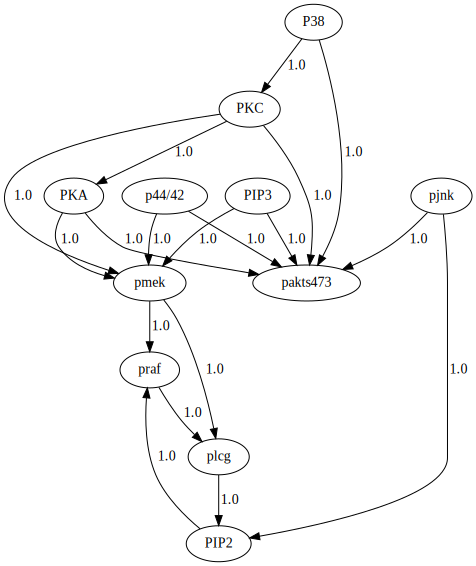

In [70]:
labels = [f'{col}' for i, col in enumerate(data_sachs.columns)]
adj_matrix = nx.to_numpy_array(graph_sachs)
adj_matrix = np.asarray(adj_matrix)
graph_dot = make_graph(adj_matrix, labels)
display(graph_dot)

# Causal Discovery with Causal Discovery Tool (CDT)

We use the three causal discovery methods mentioned above (PC, GES, and LiNGAM) to find the causal graphs.

First, let us take a look at how PC works.

  0%|          | 0/11 [00:00<?, ?it/s]

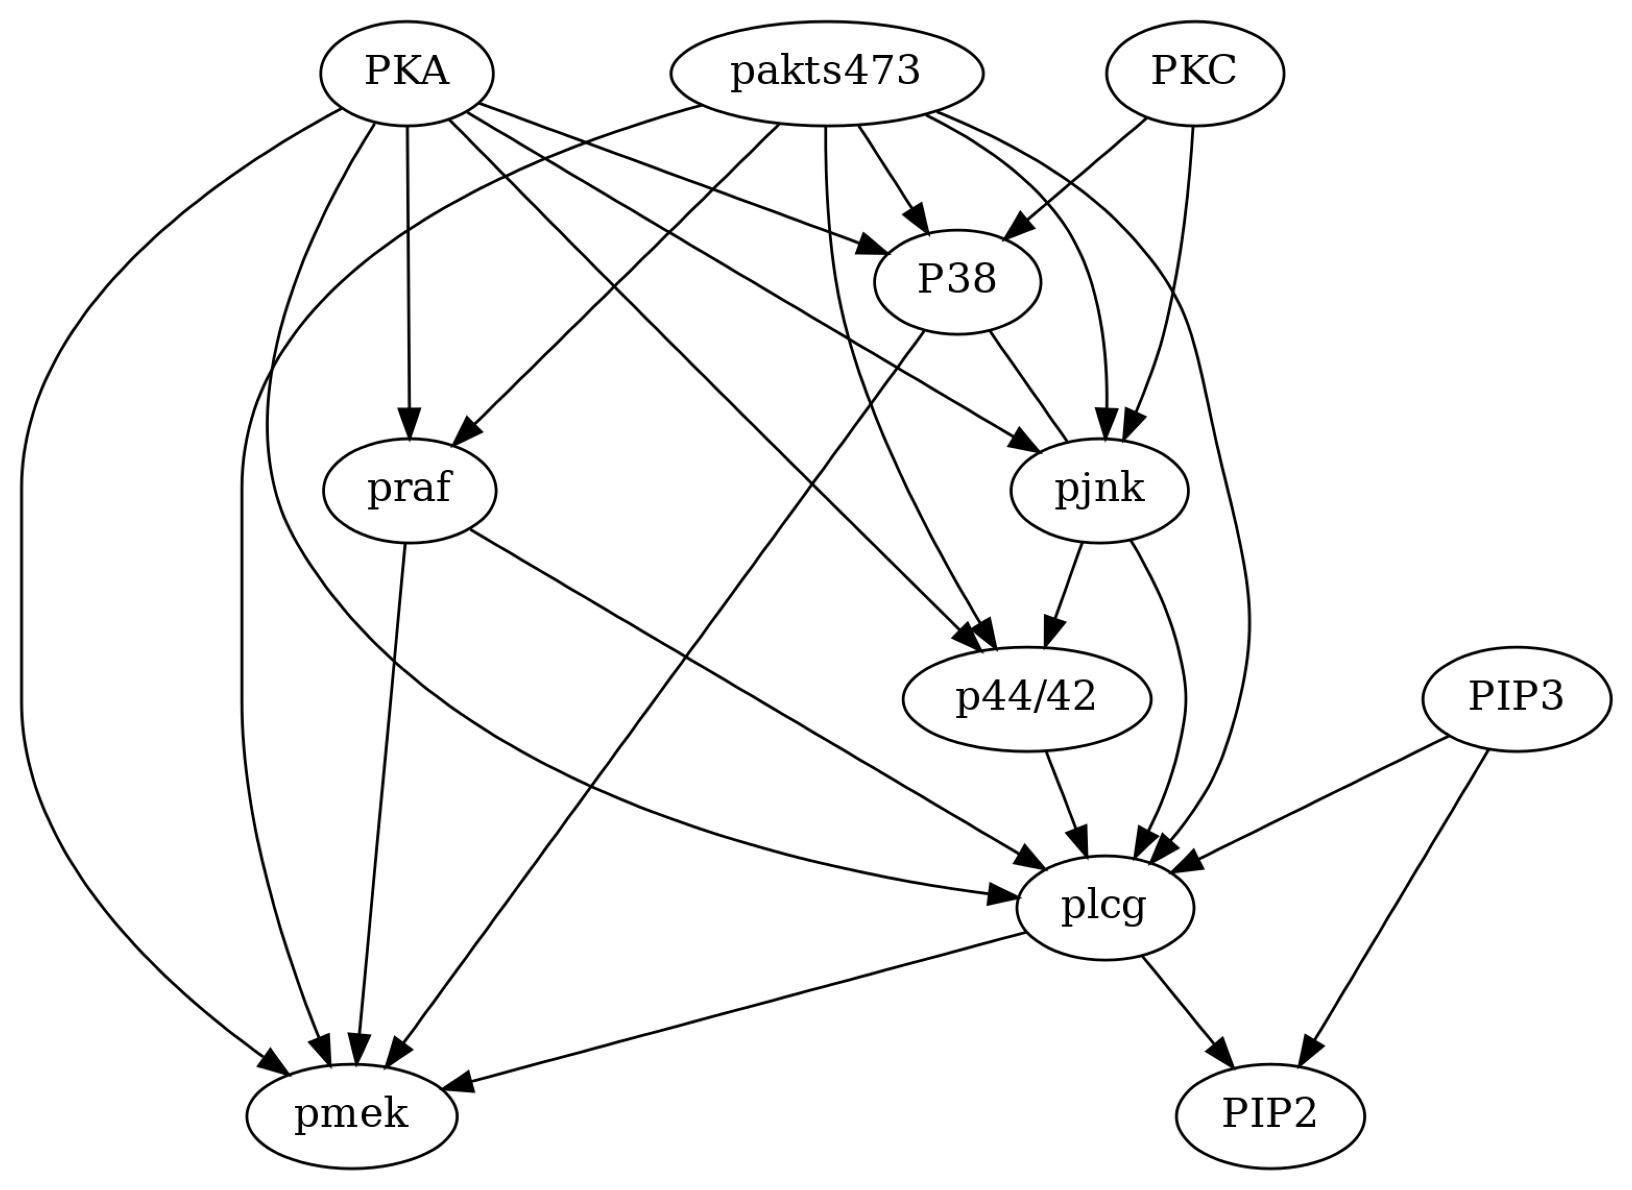

In [71]:
graphs = {}
graphs_nx = {}
labels = [f'{col}' for i, col in enumerate(data_sachs.columns)]
data = data_sachs.to_numpy()

from causallearn.search.ConstraintBased.PC import pc

cg = pc(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

Then, let us try GES.

[[ 0  1  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 

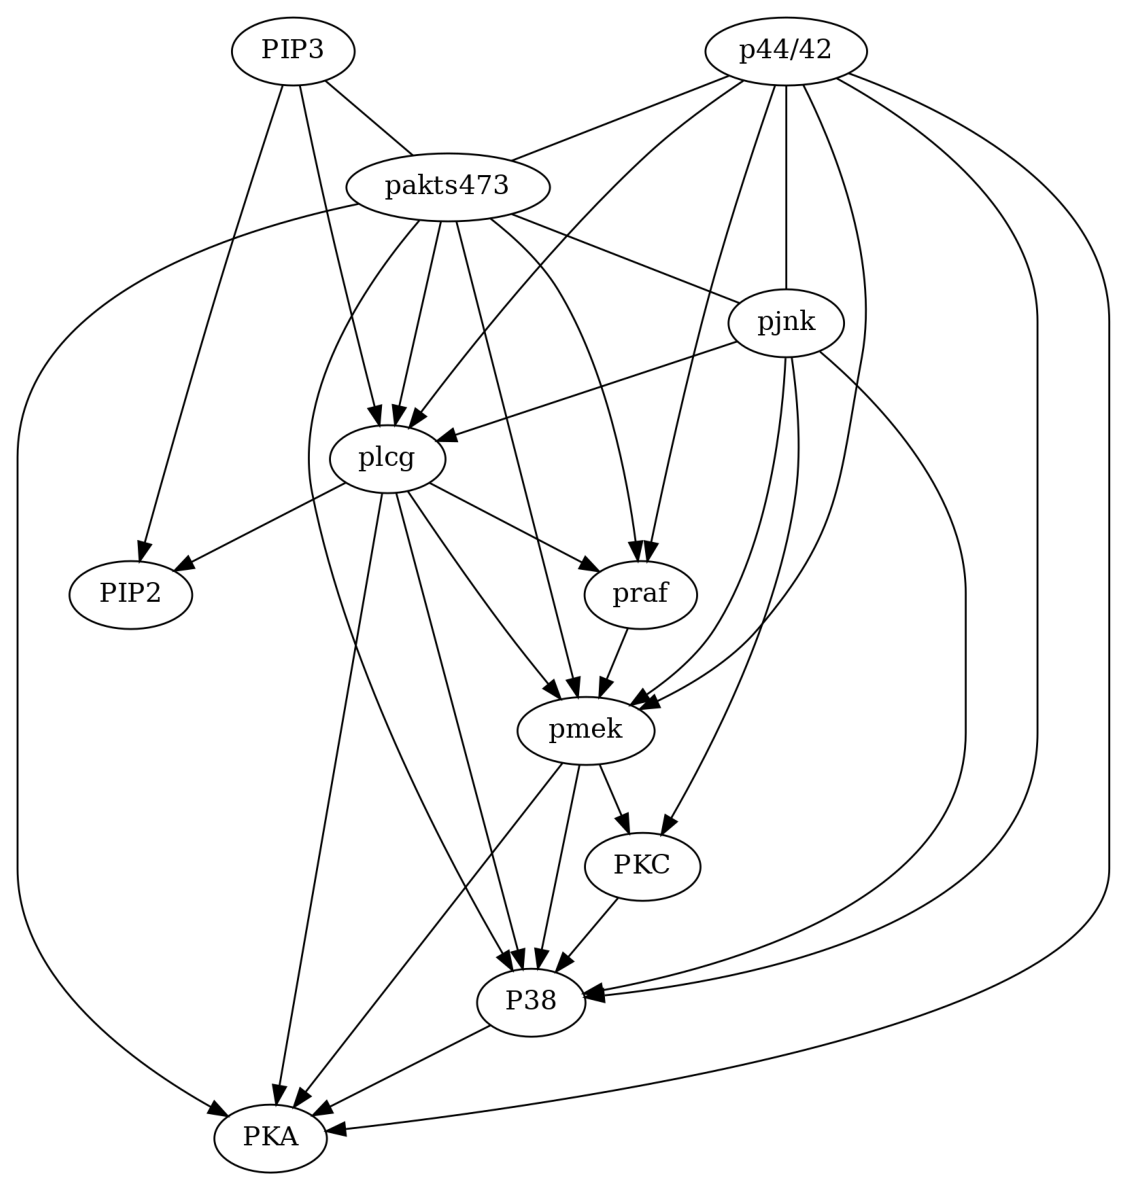

In [72]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

And also LiNGAM.

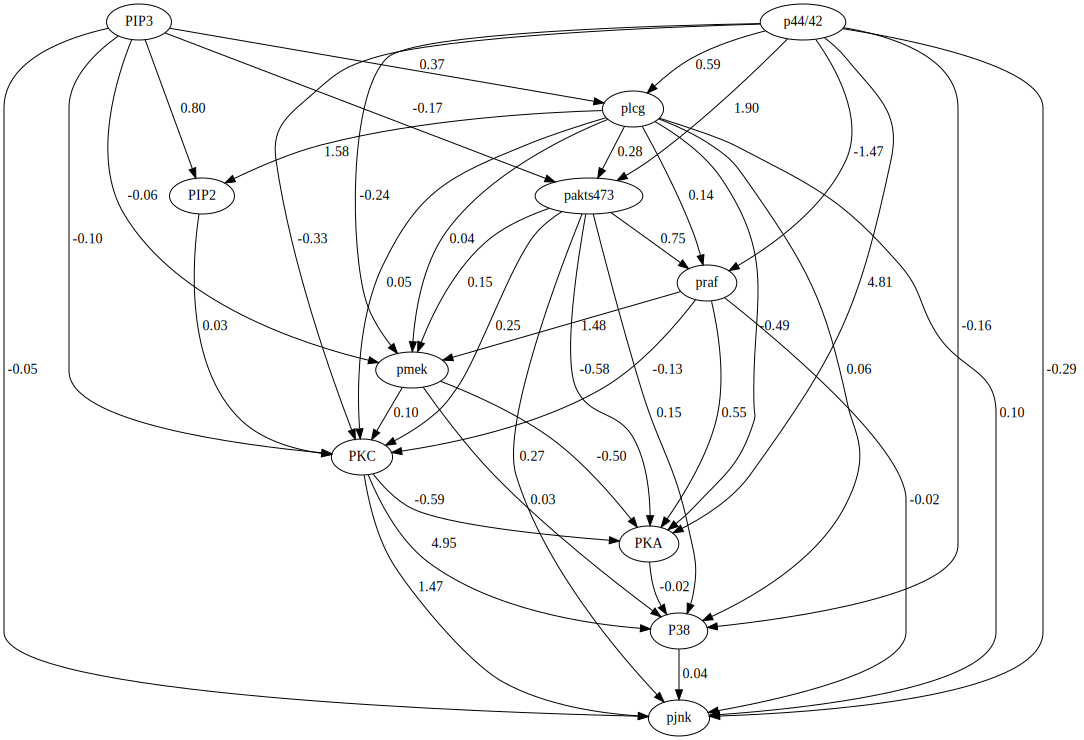

In [86]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

## Estimate effects using Linear Regression

Similarly, let us use the DAG returned by LiNGAM to estimate the causal effect of *PIP2* on *PKC*.

In [87]:
# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

# Define Causal Model
model=CausalModel(
        data = data_sachs,
        treatment='PIP2',
        outcome='PKC',
        graph=str_to_dot(graph_dot.source))

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                     
───────(E[PKC|plcg,PIP3])
d[PIP₂]                  
Estimand assumption 1, Unconfoundedness: If U→{PIP2} and U→PKC then P(PKC|PIP2,plcg,PIP3,U) = P(PKC|PIP2,plcg,PIP3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is 0.03397189228452646
